##**Data Import**

In [1]:
!unzip -u "/content/Data_Receptors.zip" -d "/content/Data_Receptors"
train_features_path = '/content/Data_Receptors/Train_Features.csv'
train_labels_path = '/content/Data_Receptors/Train_Labels.csv'
test_features_path = '/content/Data_Receptors/Test_Features.csv'

Archive:  /content/Data_Receptors.zip
  inflating: /content/Data_Receptors/Test_Features.csv  
  inflating: /content/Data_Receptors/Train_Features.csv  
  inflating: /content/Data_Receptors/Train_Labels.csv  


##**Μέρος 2α,β)**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import csv

train_features = np.genfromtxt(train_features_path, delimiter=',')
train_labels = np.genfromtxt(train_labels_path, delimiter=',')
test_features = np.genfromtxt(test_features_path, delimiter=',')

#split train_features.csv data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=33)

In [3]:
#normalize data to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

#fit and transform the scaled data using PCA
pca = PCA()
pca_res = pca.fit_transform(X_train_scaled)

#calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

#calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

#find the n components in order to have the desired variance
desired_variance = 0.99
n_components = np.argmax(cumulative_explained_variance >= desired_variance) + 1
print(f"Number of components to retain {desired_variance*100}% of variance is: {n_components}")

Number of components to retain 99.0% of variance is: 333


In [7]:
#fit and transform the scaled data using PCA
pca = PCA(n_components = n_components)
X_train_pca = pca.fit_transform(X_train_scaled)

#define hyperparameters grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 10,15,20,25,30,35],
}

#initialize Random Forest Classifier
rf_classifier = RandomForestClassifier()

#perform grid search with cross-validation
grid_search = GridSearchCV(
    rf_classifier,
    param_grid,
    cv=5,
    scoring='accuracy'
)

#fit the model with the best hyperparameters
grid_search.fit(X_train_pca, y_train)

#get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

#train the model with the best hyperparameters
final_rf_classifier = RandomForestClassifier(**best_params)
final_rf_classifier.fit(X_train_pca, y_train)

#normalize validation data to have zero mean and unit variance
X_val_scaled = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scaled)

#find model accuracy for validation set
val_predictions = final_rf_classifier.predict(X_val_pca)
accuracy = np.mean(val_predictions == y_val)
print("Validation accuracy with best Hyperparameters:", accuracy)
print("Error in validation set: ",1-accuracy)

Best hyperparameters: {'max_depth': 35, 'n_estimators': 250}
Validation accuracy with best Hyperparameters: 0.9192825112107623
Error in validation set:  0.08071748878923768


##**Μέρος 2γ)**

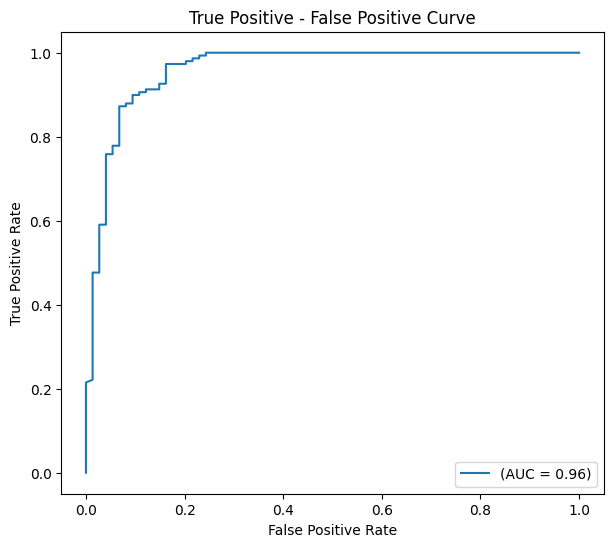

In [5]:
from sklearn.metrics import roc_curve, auc

#get the predicted probabilities
rf_probs = final_rf_classifier.predict_proba(X_val_pca)[:, 1]

#calculate false positive rate and true positive rate values
fpr, tpr, _ = roc_curve(y_val, rf_probs)
auc_score = auc(fpr, tpr)

#plot TP-FP curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label='(AUC = {:.2f})'.format(auc_score))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('True Positive - False Positive Curve')
plt.legend(loc='lower right')
plt.show()

In [6]:
def save_predictions(model, test_data):
    filename ='test_predictions.csv'

    #scale and apply PCA to the test data
    X_test_scaled = scaler.transform(test_data)
    X_test_pca = pca.transform(X_test_scaled)

    #get predicted probabilities
    predicted_probs = model.predict_proba(X_test_pca)

    #save predictions to csv file
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['predicted_label', 'prediction_score'])
        for pred_row in predicted_probs:
            predicted_label = model.classes_[pred_row.argmax()]  #save the class label with the highest probability
            pred_score = pred_row.max()  #find the corresponding probability score
            writer.writerow([f'{predicted_label}', f'{pred_score:.4f}'])

save_predictions(final_rf_classifier, test_features)